In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [4]:
#Simulate 2 hours of time in one minute intervals
time = np.linspace(0,120,121)

#Simulate pump rate (in bpm), assuming a short injection rate 5 minutes after the job begins, lasting for 5 minutes
pump_rate = np.zeros_like(time)
pump_rate[5:10] = 20

In [30]:
# Simulate pressure data (in psi)
# Injection phase: slight pressure increase due to pumping
pressure = np.zeros_like(time, dtype = float)
pressure[:5] = 2000
for i in range(5,len(time)):
    if i < 10:
        pressure[i] = pressure[i-1] + random.uniform(10,20)
    elif i < 80:
        # Pressure falloff after shut-in, modeled as exponential decline + noise
        pressure[i] = pressure[9] * np.exp(-.1 * (i - 9)) + np.random.normal(0, .5)
    else:
        # Reservoir-dominated: slower decay, stabilizing toward a reservoir pressure
        pressure[i] = pressure[i-1] - np.exp(-0.02 * (i - 40)) + np.random.normal(0, 0.1)

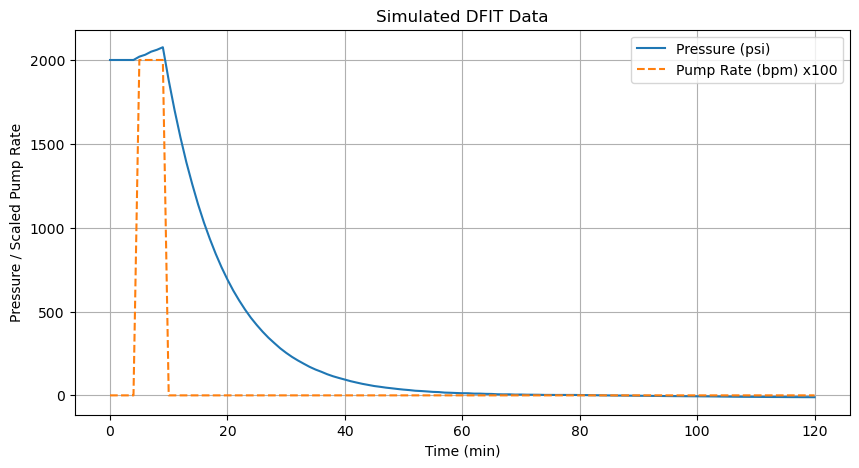

In [31]:
# Create a DataFrame
dfit_data = pd.DataFrame({
    "Time_min": time,
    "Pump_Rate_bpm": pump_rate,
    "Pressure_psi": pressure
})
# Also plot the data for visualization
plt.figure(figsize=(10, 5))
plt.plot(time, pressure, label='Pressure (psi)')
plt.plot(time, pump_rate * 100, label='Pump Rate (bpm) x100', linestyle='--')  # scaled for visibility
plt.xlabel("Time (min)")
plt.ylabel("Pressure / Scaled Pump Rate")
plt.title("Simulated DFIT Data")
plt.legend()
plt.grid(True)
plt.show()

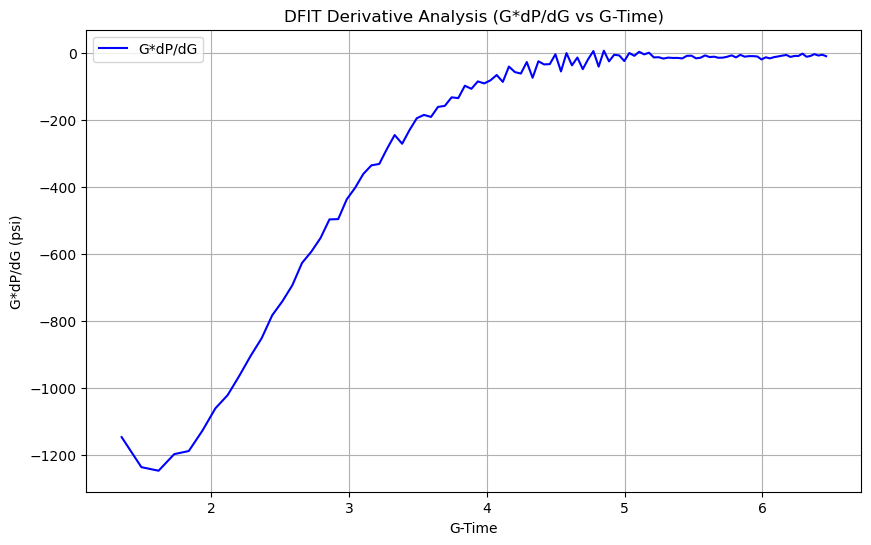

In [32]:
import math

# Recalculate G-time based on Carter & Durlofsky (or similar) G-function form:
# G(t) = 4/pi * [(1 + Δt)^1.5 - (Δt)^1.5] where Δt = t / tp (tp = shut-in time)

tp = 10  # Shut-in starts at 10 minutes
delta_t = (time[10:] - tp) / tp
g_time = (4 / math.pi) * ((1 + delta_t) ** 1.5 - (delta_t) ** 1.5)

# Pressure and time after shut-in
pressure_shutin = pressure[10:]
g_dp = pressure_shutin[1:] - pressure_shutin[:-1]
g_dg = g_time[1:] - g_time[:-1]
g_derivative = g_dp / g_dg

# Midpoints for plotting
g_time_mid = (g_time[1:] + g_time[:-1]) / 2

# Create a DataFrame for plotting and further analysis
dfit_g_data = pd.DataFrame({
    "G_time": g_time_mid,
    "Pressure": pressure_shutin[1:],
    "G_dP/dG": g_derivative
})

import matplotlib.pyplot as plt

# Plot G*dP/dG
plt.figure(figsize=(10, 6))
plt.plot(dfit_g_data["G_time"], dfit_g_data["G_dP/dG"], label="G*dP/dG", color="blue")
plt.xlabel("G-Time")
plt.ylabel("G*dP/dG (psi)")
plt.title("DFIT Derivative Analysis (G*dP/dG vs G-Time)")
plt.grid(True)
plt.legend()
plt.show()